#### Last Modified: June 10th, 2022 (Opal). 

# sOpInf applied to the Inviscid Burgers' Equation (Example #1) - Find the shift function c(t) via (1) the method of characteristics and (2) cross-correlation extrapolation.

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/oissan/PycharmProjects/Space-Weather-ROM-Revised'

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import rom_operator_inference as roi
import scipy
import numpy as np 
import time
import astropy.units as u

In [3]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

# Option 1: Method of Characteristics (MoC)

### Invisicid Burgers' Equation
The one-dimensional invisicid Burgers' equation is of the form:

\begin{equation} \label{inviscid-burgers-equation}
    \frac{\partial u(x, t)}{\partial t} + u(x, t)\frac{\partial u(x, t)}{\partial x} = 0
\end{equation}

The characteristic curves are defined as 
$$
\frac{d \tilde{x}}{dt} = u \qquad \text{and} \qquad \frac{du(\tilde{x}, t)}{dt} = 0
$$

Shock forms when the characteristic lines first intersect - beyond this point $(x_{s}, t_{s})$ the solution develops a discontinuity and the wave "breaks". It is also the point where the conservation law, in its differential form, breaks down. In order to avoid a multi-valued solution, the triple-valued region is replaced with a discontinuity. 


### Set Rectangular Computational Grid Size

In [5]:
# number of mesh points in the T (time) axis. 
m = 1000
# number of mesh points in X (spatial) axis. 
n = 500
# final time. 
T = 2
# boundary of x [a, b].
a = 0
b = 3

In [6]:
# time and spatial grid (uniform spacing).
t_vec = np.linspace(0, T, m)
x_vec = np.linspace(a, b, n)

### Set Initial Condition

In [7]:
# gaussian initial condition
initial_condition = 0.8 +  0.5*np.exp(-(x_vec - 1)**2/(0.1))

The initial condition is of the form 

$$
u_{0}(x) = 0.8 + 0.5\exp(-10(x-1)^2)
$$

The nonlinear steepening produces the shock at $(x_{s}, t_{s}, \tilde{x}_{s})$ and these three unknowns are determined from solving the coupled system of equations:
$$
u_{0}''(\tilde{x}_{s}) = 0,\\
1 + t_{s} u_{0}'(\tilde{x}_{s}) = 0,\\
x_{s} = \tilde{x}_{s} + t_{s} u_{0}(\tilde{x}_{s}).
$$

Since $u_{0}'(\tilde{x}_{s}) = -10(x-1)\exp(-10(x-1)^2)$
and $u_{0}''(\tilde{x}_{s}) = (200x^2 - 400x + 190) \exp(-10(x-1)^2) = 0$, 
the characteritsic where shock emerges begins at $\tilde{x}_{s} = \frac{10 \pm \sqrt{5}}{10}$. The second equation yields the time where the shock emerges ,$t_s$, i.e.
$$
t_{s} =\frac{-1}{u_{0}'(\tilde{x}_{s})} = \frac{-1}{-10(\tilde{x}_{s}-1)\exp(-10(\tilde{x}_{s}-1)^2)} = \pm \frac{1}{\sqrt{5} \exp \left(-\frac{1}{2}\right)},
$$
and since $t_{s} > 0$, we get $t_{s} \approx 0.737$. Lastly, the shock spatial location is at
$$
x_{s} = \frac{10 + \sqrt{5}}{10} + \frac{1}{\sqrt{5} \exp \left(-\frac{1}{2}\right)} u_{0} \left(\frac{10 + \sqrt{5}}{10}\right) \approx 2.037
$$

In [8]:
def u_0(x):
    """ Initial condition (gaussian)"""
    return 0.8 + 0.5*np.exp(-10*((x-1)**2))

def u_tag(x):
    """ the first derivative (of u0)"""
    return -10*(x-1)*np.exp(-10*((x-1)**2))

def u_tag_tag(x):
    """ the second derivative (of u0)"""
    return (200*(x**2) - 400*x + 190)*np.exp(-10*((x-1)**2))

In [9]:
x_s_tilde = (10 + np.sqrt(5))/10
print("x_s_tilde = ", x_s_tilde)

x_s_tilde =  1.223606797749979


In [10]:
t_s = -1/u_tag(x_s_tilde)
print("t_s = " + str(t_s))

t_s = 0.7373305674470638


In [11]:
x_s = x_s_tilde + t_s * u_0(x_s_tilde)
print("x_s = ", + x_s)

x_s =  2.037078049457609


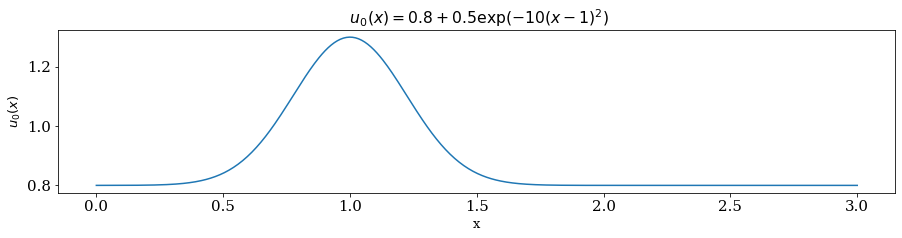

In [12]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(x_vec, initial_condition)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("$u_{0}(x)$")
_ = ax.set_title(" $u_{0}(x) = 0.8 + 0.5\exp(-10(x-1)^2)$" )

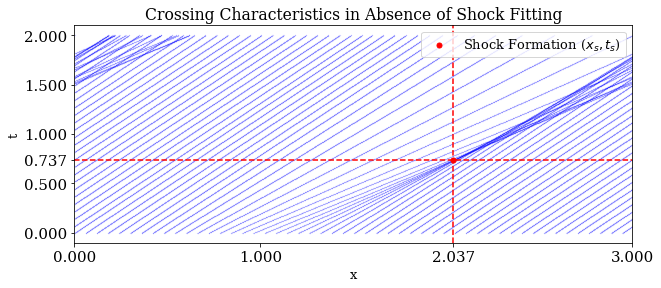

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
for ii in np.arange(0, len(x_vec), 10):
    ax.scatter((x_vec[ii] + initial_condition[ii]*t_vec) % b,t_vec, color="b", s=0.05, alpha=0.3)

_ = ax.set_xlim(0, 3)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("t")
_ = ax.set_title("Crossing Characteristics in Absence of Shock Fitting")
_ = ax.scatter(x_s, t_s, s = 25, color="r", label=r"Shock Formation ($x_{s}, t_{s}$)")
_ = ax.axvline(x_s, ls="--", c="r")
_ = ax.axhline(t_s, ls="--", c="r")
_ = ax.set_xticks([0, 1,  round(x_s, 3), 3])
_ = ax.set_yticks([0, 0.5, round(t_s, 3), 1, 1.5, 2])
_ = ax.legend()

# Shock Fitting
To determine the shock path we must solve the following system (the Rankine-Hugoniot condition):

$$
s(t) = \tilde{x}_{+}+ t u_{0}(\tilde{x_{+}}, 0)\\
s(t) = \tilde{x}_{-}+ t u_{0}(\tilde{x_{-}}, 0)\\
\dot{s}(t) = \frac{1}{2} \left[ u_{0}(\tilde{x}_{-})  + u_{0}(\tilde{x}_{+})\right]
$$
where $\tilde{x}_{+}$ is the characteristic right after the shock and $\tilde{x}_{+}$ is the characteristic right before the shock. Since $\tilde{x}_{+}$ and $\tilde{x}_{-}$ change with time, computing $s(t)$ is non-trivial in many cases. 

Fortunately, instead, we can use the Whitham (1974) equal-area rule: on the multi-valued solution at time t the shock s(t) is located by drawing a vertical line which cuts off equal area lobes. If we replace part of the multivalued solution interval with a shock, some mass will be removed (area  A1  in the figure below) and some mass will be added (area  A2  in the figure below). Number conservation means that when we replace the multivalued solution by the discontinuous one, the area under the curve must remain the same, thus, $A1 = A2$. 

![image](./figs/characteristic_lines_equal_area.png)

In [14]:
def area_compute(index1, index2, x_shifted, u):
    """ function to compute area between a vertical line x=s(t) and
    the multivalued function u(x, t)"""
    tot_area = 0
    for ii in np.arange(index1, index2):
        dx = np.abs(x_vec[ii+1] - x_vec[ii])
        du = np.abs(u[ii+1] - u[ii])
        tot_area += dx*du
    return tot_area


def get_index(diff):
    """ get indexes where x=s(t) and the multivalued function u(x, t) intercept"""
    asign = np.sign(diff)
    signchange = (np.diff(asign) != 0)*1
    return np.where(signchange==1)[0]

In [15]:
def get_s_opt(t_idx, x_vec, t_vec, a, b, initial_condition, n_search=int(1e4)):
    """ function to get the optimal s (shock) based on Whitham (1974) geometrical arguments """
    # shifted coordinates
    x_shifted = (x_vec + initial_condition*t_vec[t_idx]) 

    # shock location initial guess
    s_vec = np.linspace(a, b*2, n_search)
    area_diff = np.zeros(n_search)

    for s_idx, s in enumerate(s_vec):
        # difference between shifted location and current shock s
        diff = x_shifted - s
        # figure out where the two curves intersect
        index = get_index(diff)

        if len(index) != 3: 
            area_diff[s_idx] = np.inf

        else:
            # compute the area between the two curves
            area1 = area_compute(index[0], index[1], x_shifted, initial_condition)
            area2 = area_compute(index[1], index[2], x_shifted, initial_condition)
            area_diff[s_idx] = np.abs(area1 - area2)

    return s_vec[np.argmin(area_diff)] #% b

In [16]:
s_curve = np.ones(len(t_vec)) * np.inf
for t_idx, tt in enumerate(t_vec):
    if tt > t_s + 1e-2:
        # s(t) -- compute for each t slice
        s_curve[t_idx] = get_s_opt(t_idx, x_vec, t_vec, a, b, initial_condition)

m =  nan
n =  nan


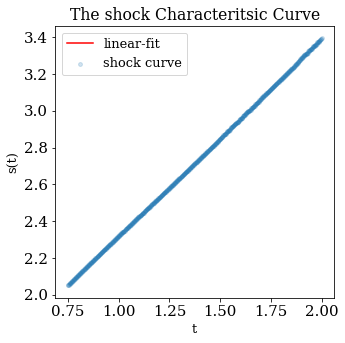

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
n_start=190
m_linear, n_linear = np.polyfit(t_vec[n_start:], s_curve[n_start:], 1)
_ = ax.scatter(t_vec[:], s_curve[:], s=15, alpha=0.2, label="shock curve")
_ = ax.plot(t_vec[n_start:], m_linear*t_vec[n_start:] + n_linear, c="r", label="linear-fit")
_ = ax.legend()
_ = ax.set_xlabel("t")
_ = ax.set_ylabel("s(t)")
_ = ax.set_title("The shock Characteritsic Curve")
print("m = ", m_linear)
print("n = ", n_linear)

# Collection of characteristic curves

In [18]:
# initialize set of characteristic curves
char_curves = np.zeros((len(x_vec), len(t_vec)))

# loop over each point
for ii in np.arange(len(x_vec)):
    for jj in np.arange(len(t_vec)):
        x_loc = (x_vec[ii] + initial_condition[ii]*t_vec[jj])
        if np.min(np.abs(s_curve[jj]%b - x_loc%b)) < 1e-3:
            char_curves[ii, jj:] = s_curve[jj:]
            break
        else:
            char_curves[ii, jj] = x_loc 

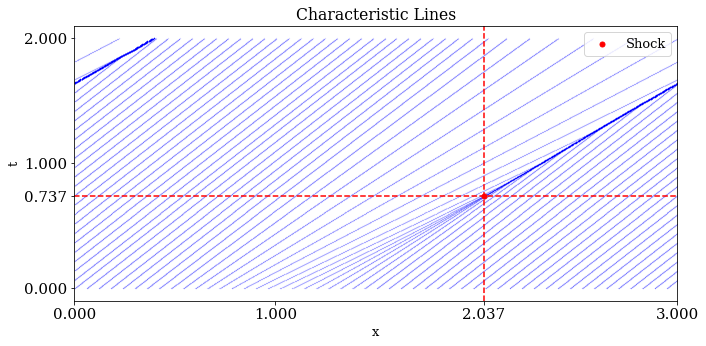

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
for ii in np.arange(0, len(x_vec), 10):
    ax.scatter(char_curves[ii, :]%b, t_vec, s=0.05, alpha=0.3, color="b")
#ax.scatter(s_curve%b,t_vec, c="red", s=0.5)

_ = ax.set_xlim(0, 3)
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("t")
_ = ax.set_title("Characteristic Lines")
_ = ax.scatter(x_s, t_s, s = 25, color="r", label=r"Shock")
_ = ax.axvline(x_s, ls="--", c="r")
_ = ax.axhline(t_s, ls="--", c="r")
_ = ax.set_xticks([0, 1,  round(x_s, 3), 3])
_ = ax.set_yticks([0, round(t_s, 3), 1,  2])
_ = ax.legend()
plt.tight_layout()
plt.savefig("Burgers/figs/characteristic_lines_shock_formation.png")

In [104]:
print(x_vec[88])
print(x_vec[270])

0.5290581162324649
1.623246492985972


In [105]:
mean_char_curve = np.zeros(len(t_vec))

for jj in np.arange(len(t_vec)):
    mean_char_curve[jj] = np.mean(char_curves[88:270, jj])
    
mean_char_curve = mean_char_curve - mean_char_curve[0]

In [106]:
def func_linear(xi, t):
    return xi*t

m_mean = scipy.optimize.curve_fit(func_linear, t_vec, mean_char_curve)[0][0]
m_mean

1.0505006289251395

Text(0.5, 1.0, 'Mean Characteristic')

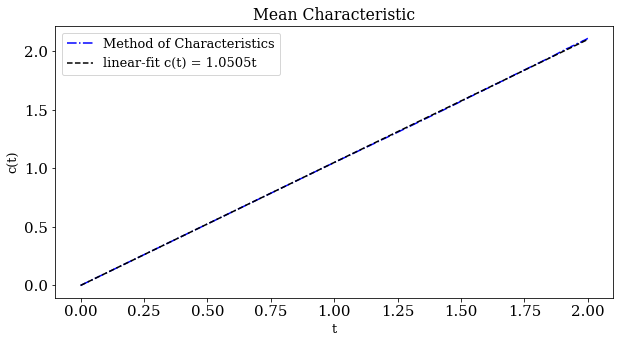

In [107]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(t_vec, mean_char_curve , c="b", ls="-.", label="Method of Characteristics")
ax.plot(t_vec, m_mean*t_vec, c="k", ls="--", label="linear-fit c(t) = " + str(round(m_mean, 4)) + "t")

ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("c(t)")
ax.set_title("Mean Characteristic")